In [7]:
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

matplotlib.rcParams.update({'font.size': 18})


In [8]:
scores_dir = Path("designed/workflow_2/scores")
combined_dir = Path("designed/workflow_2/combined")
max_round = 4
spikes = ["KP.3", "JN.1"]
nanobodies = ["Nb21", "Ty1"]
score_types = ["log_likelihood_ratio", "Interface_pLDDT", "Interface_Residue_Count", "Interface_Atom_Count", "dG_separated", "weighted_score"]

sns.set_style("white")

figure_dir = Path("figures/nanobody_analysis_workflow_2")
figure_dir.mkdir(parents=True, exist_ok=True)

linewidth = 4
s = 250

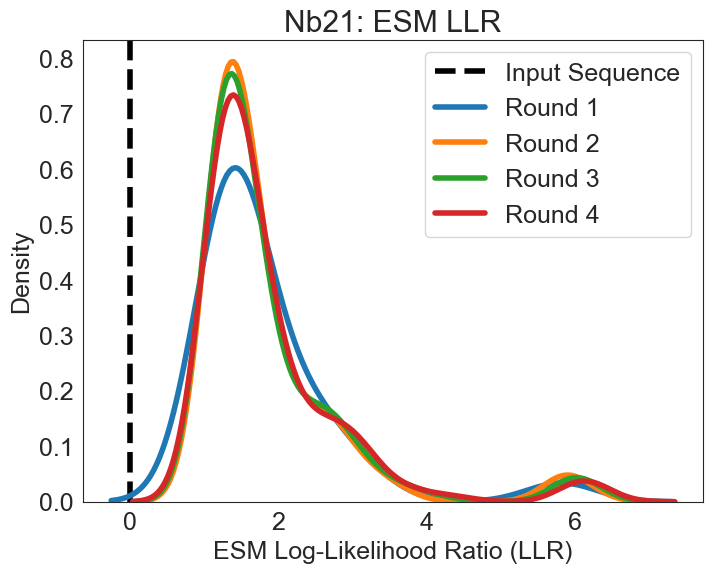

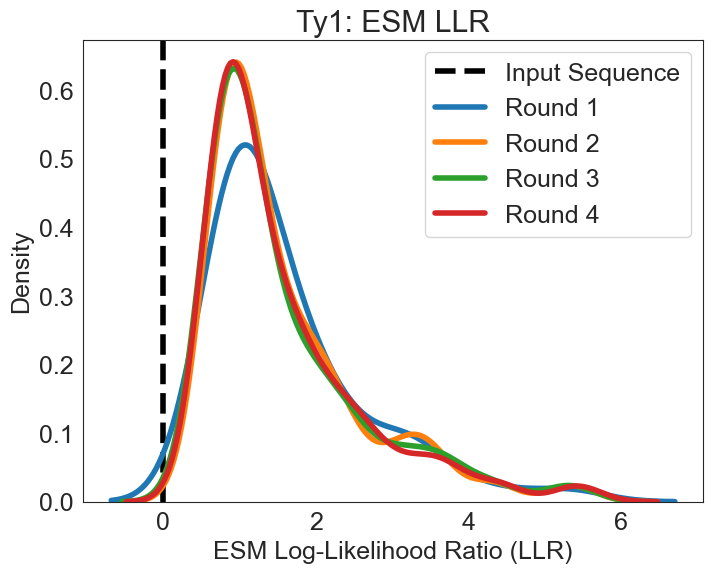

In [9]:
# Plot ESM scores across rounds (all top 50 designs per input nanobody sequence)
for nanobody in nanobodies:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.axvline(0, color="black", linestyle="--", label="Input Sequence", linewidth=linewidth)
    for round_num in range(1, max_round + 1):
        scores_path = scores_dir / f"round_{round_num}_scores" / f"{nanobody}_all.csv"
        scores = pd.read_csv(scores_path)
        sns.kdeplot(data=scores, x="log_likelihood_ratio", label=f"Round {round_num}", ax=ax, linewidth=linewidth)
    ax.set_title(f"{nanobody}: ESM LLR")
    ax.set_xlabel("ESM Log-Likelihood Ratio (LLR)")
    plt.legend()
    plt.savefig(figure_dir / f"{nanobody}_rounds_esm_llr.pdf", bbox_inches="tight")

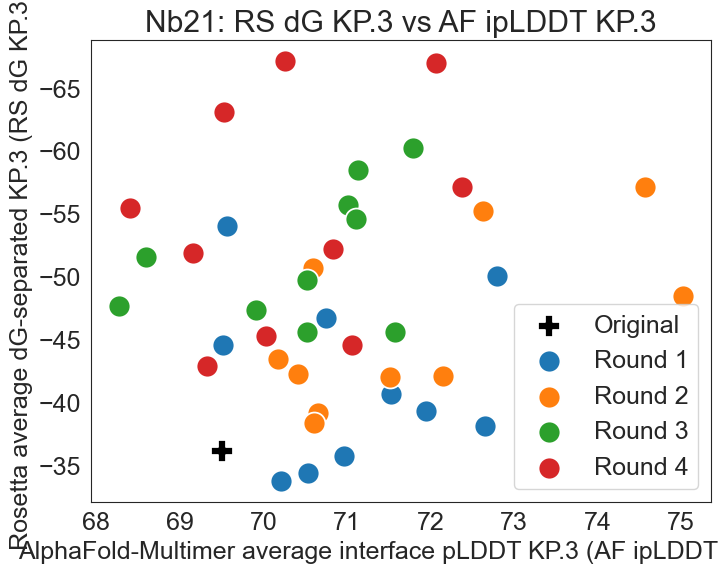

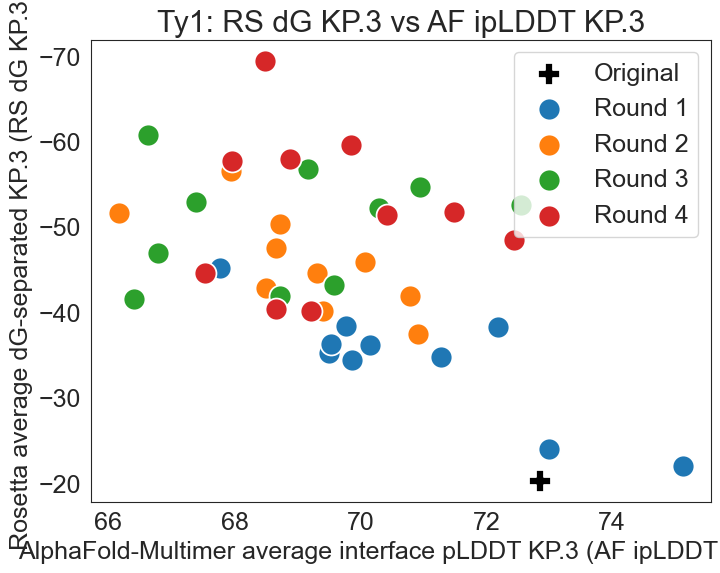

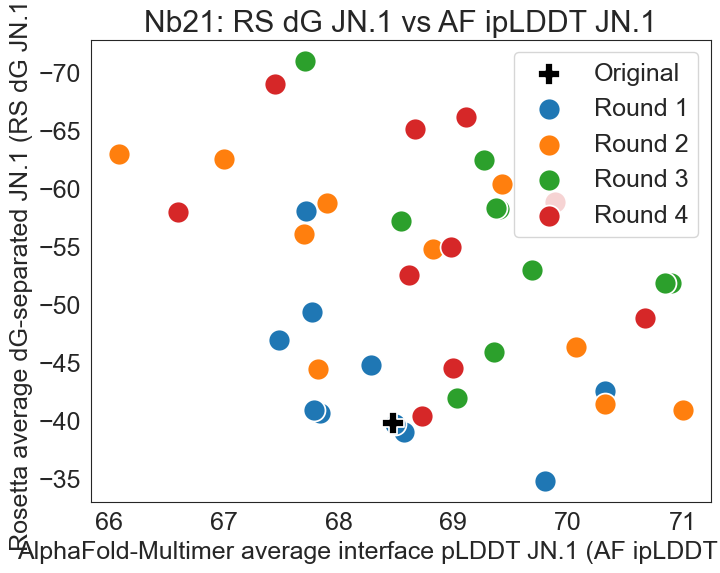

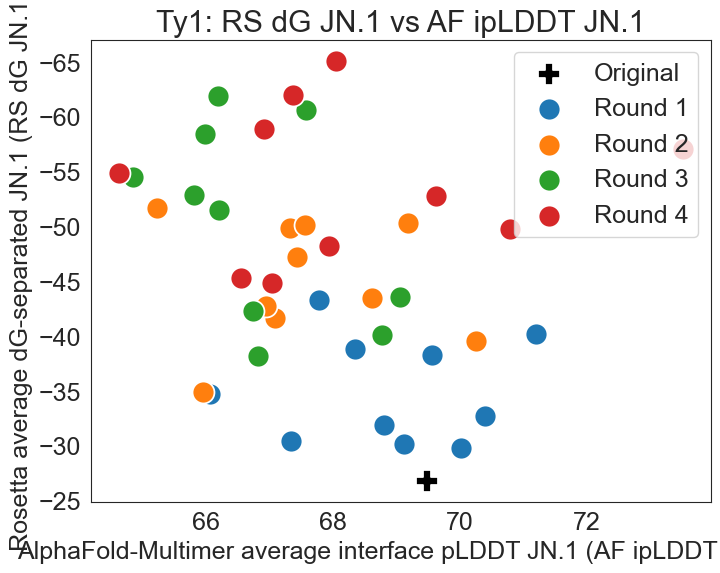

In [10]:
# Plot AlphaFold-Multimer ipLDDT vs Rosetta dG_separated scores across rounds (top 10 from each round)
for spike in spikes:
    for nanobody in nanobodies:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        for round_num in range(max_round + 1):
            scores_path = scores_dir / f"round_{round_num}_scores" / f"{nanobody}.csv"
            scores = pd.read_csv(scores_path)
            kwargs = {"label": f"Round {round_num}"} if round_num > 0 else {"label": "Original", "color": "black", "marker": "P", "zorder": 10}
            sns.scatterplot(data=scores, x=f"Average_Interface_pLDDT_{spike}", y=f"Average dG_separated_{spike}", ax=ax, s=s, **kwargs)
        ax.invert_yaxis()
        ax.set_title(f"{nanobody}: RS dG {spike} vs AF ipLDDT {spike}")
        ax.set_xlabel(f"AlphaFold-Multimer average interface pLDDT {spike} (AF ipLDDT {spike})")
        ax.set_ylabel(f"Rosetta average dG-separated {spike} (RS dG {spike})")
        plt.legend()
        plt.savefig(figure_dir / f"{nanobody}_rounds_rs_dg_vs_af_iplddt_{spike}.pdf", bbox_inches="tight")

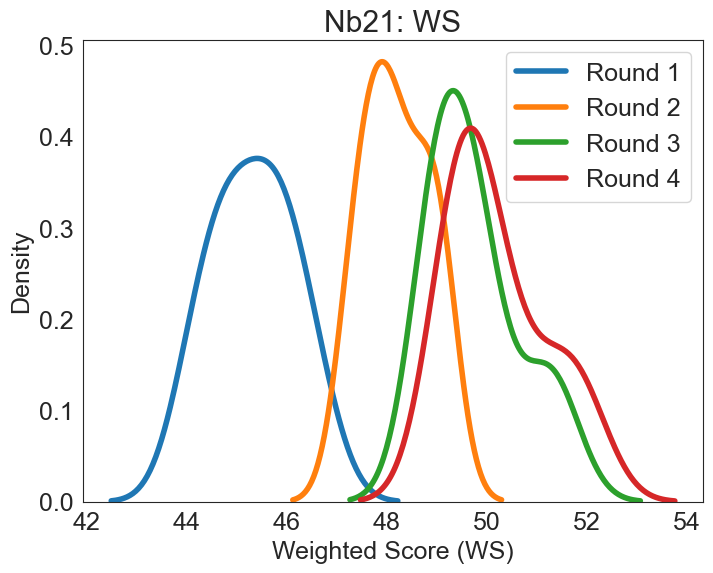

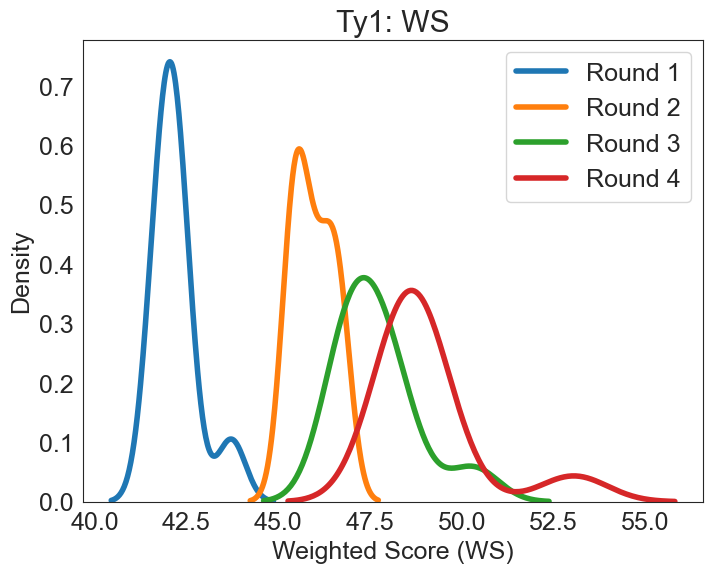

In [11]:
# Plot weighted scores of best designs across rounds
for nanobody in nanobodies:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for round_num in range(1, max_round + 1):
        scores_path = scores_dir / f"round_{round_num}_scores" / f"{nanobody}.csv"
        scores = pd.read_csv(scores_path)
        sns.kdeplot(data=scores, x="weighted_score", label=f"Round {round_num}", ax=ax, linewidth=linewidth)
    ax.set_title(f"{nanobody}: WS")
    ax.set_xlabel("Weighted Score (WS)")
    plt.legend()
    plt.savefig(figure_dir / f"{nanobody}_weighted_score.pdf", bbox_inches="tight")

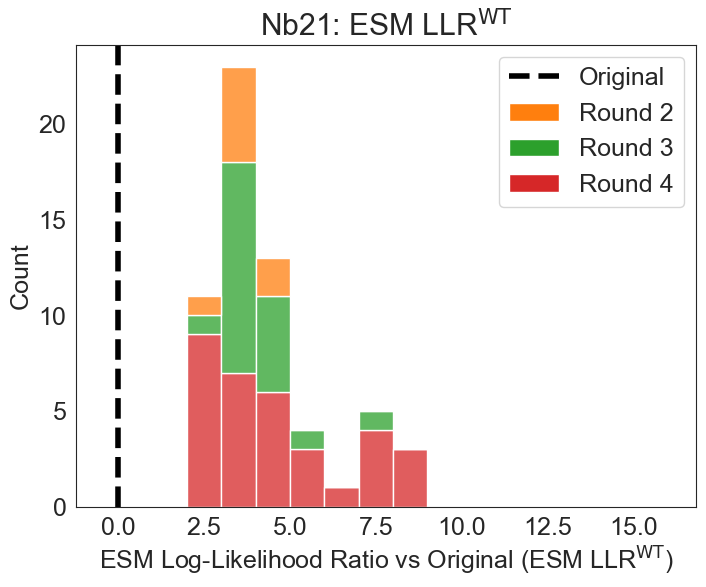

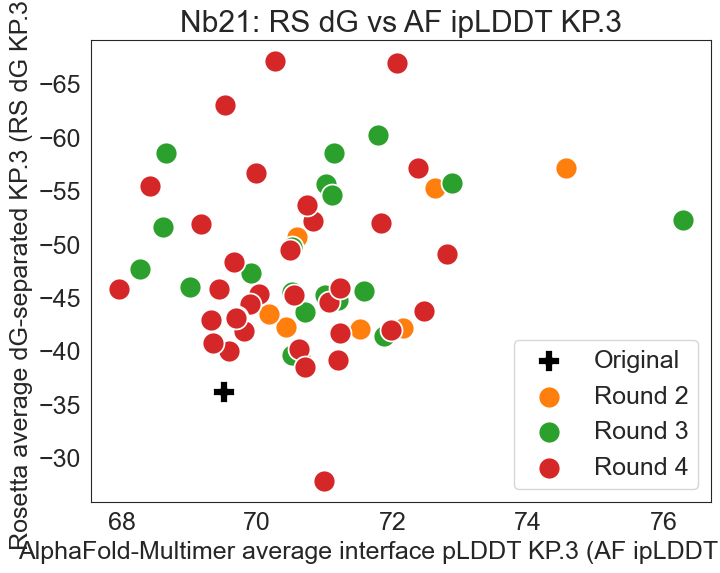

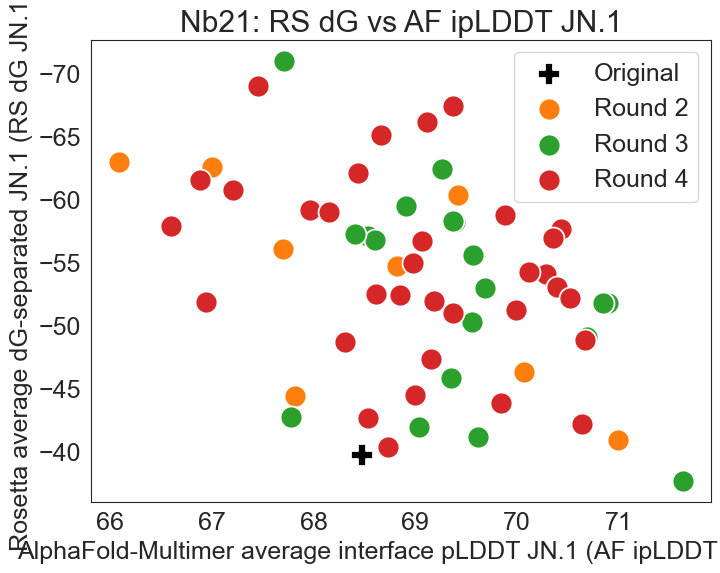

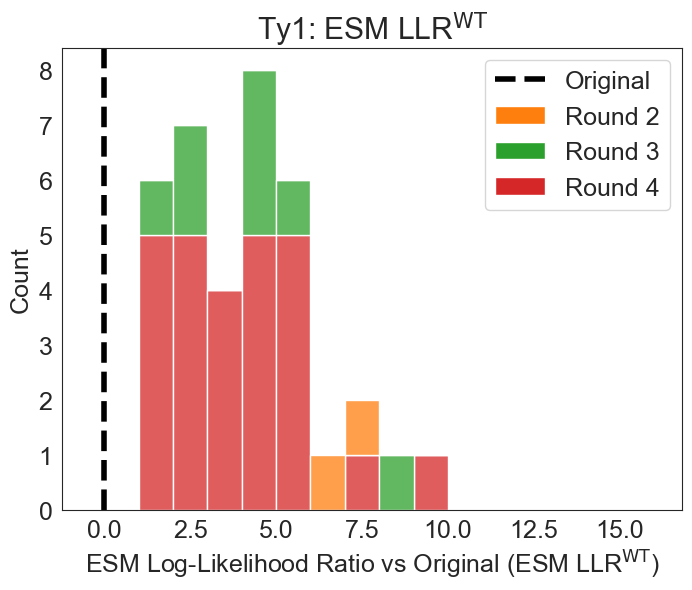

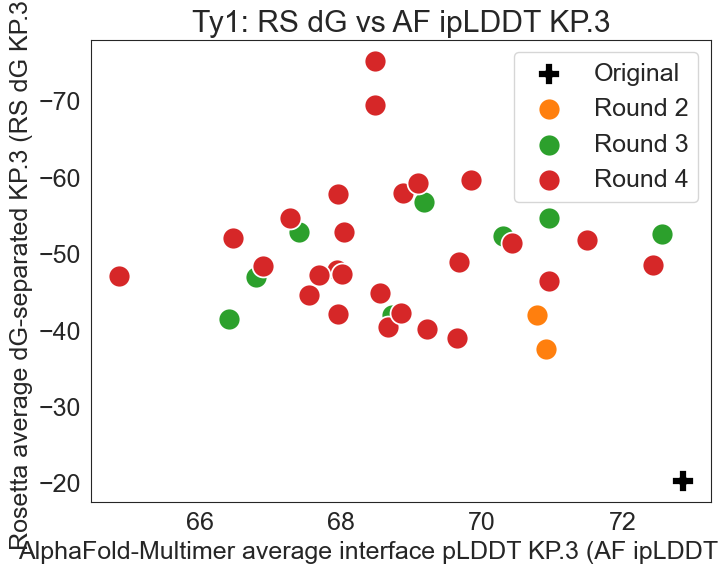

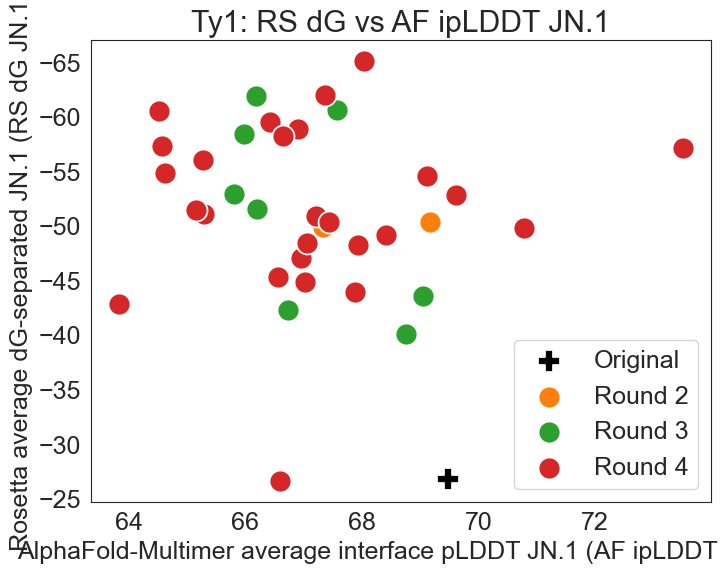

In [12]:
# Plot best designs for each nanobody
bins = np.linspace(0, 16, 17)
rounds = list(range(1, max_round + 1))
for nanobody in nanobodies:
    scores = pd.read_csv(combined_dir / f"{nanobody}.csv")

    # Plot ESM scores
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for round_num in rounds:
        if round_num in scores["round_num"].values:
            plt.bar(0, 0, color=sns.color_palette("tab10")[round_num - 1], label=f"Round {round_num}")  # Dummy bar for legend
    sns.histplot(data=scores, x="log_likelihood_ratio_vs_original", bins=bins, multiple="stack", hue="round_num", hue_order=rounds, palette="tab10", ax=ax)
    ax.axvline(0, color="black", linestyle="--", label="Original", linewidth=linewidth)
    ax.set_title(f"{nanobody}: " + r"ESM LLR$^{\text{WT}}$")
    ax.set_xlabel(r"ESM Log-Likelihood Ratio vs Original (ESM LLR$^{\text{WT}}$)")
    plt.legend()
    plt.savefig(figure_dir / f"{nanobody}_final_esm_llr.pdf", bbox_inches="tight")

    # Plot AlphaFold-Multimer ipLDDT vs Rosetta dG_separated scores
    for spike in spikes:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        original = pd.read_csv(scores_dir / "round_0_scores" / f"{nanobody}.csv")
        sns.scatterplot(data=original, x=f"Average_Interface_pLDDT_{spike}", y=f"Average dG_separated_{spike}", label="Original", color="black", marker="P", s=s, zorder=10)
        for round_num in range(1, max_round + 1):
            round_scores = scores[scores["round_num"] == round_num]
            sns.scatterplot(data=round_scores, x=f"Average_Interface_pLDDT_{spike}", y=f"Average dG_separated_{spike}", label=f"Round {round_num}", s=s, ax=ax)
        ax.invert_yaxis()
        ax.set_title(f"{nanobody}: RS dG vs AF ipLDDT {spike}")
        ax.set_xlabel(f"AlphaFold-Multimer average interface pLDDT {spike} (AF ipLDDT {spike})")
        ax.set_ylabel(f"Rosetta average dG-separated {spike} (RS dG {spike})")
        plt.legend()
        plt.savefig(figure_dir / f"{nanobody}_final_rs_dg_vs_af_iplddt_{spike}.pdf", bbox_inches="tight")